# trainning U-NET


In [1]:
import os
import numpy as np
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, merge
from keras.optimizers import SGD, Adam
from keras.layers import Convolution2D, MaxPooling2D, Convolution3D, MaxPooling3D,UpSampling2D
from keras.layers import Conv2D
from keras.layers.merge import concatenate
from keras.utils import np_utils
from keras import backend as K
from glob import glob
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from keras.models import load_model

# #Defining some functions for train

In [2]:
def read_indexfile(indexfilepath):
    f = open(indexfilepath,'r')
    res = []
    for line in  f.readlines():
        line = line.strip('\n')
        line = line.replace('\\','/')
        res.append(line)
    return res


# change the loss function
def dice_coef(y_true, y_pred):
    smooth = 0.1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0-dice_coef(y_true, y_pred)




def settings():
    st = {}
    st['initial_lr'] = 1e-5
    st['optimizer'] = Adam(lr = st['initial_lr'])
    st['loss'] = dice_coef_loss
    st['metrics'] = dice_coef
    st['batch_size'] = 32
#    metrics = settings.get('metrics', [dice_coef])

    
def solve(model, inputs):
    
    initial_lr = 1e-5
    optimizer = Adam(lr = initial_lr)
    loss = dice_coef_loss
    metrics = dice_coef
    batch_size = 32
    nb_epoch = 100

    model.compile(optimizer = optimizer, loss = dice_coef_loss, metrics = [dice_coef])
    hist = model.fit(x=inputs[0], y=inputs[1], batch_size=batch_size, nb_epoch=nb_epoch, verbose=True,
                     shuffle=True)  #validation_split=0.2, validation_data=settings['valdata'])

    
def loadData(dataset_name):
    ###################################
    # 此处待改
    # 处理数据，原始数据可得到0,1值的数据，输出是[n,64,64,64,1]的数据，float32：0.0和1.0
    # data = glob(os.path.join("./data", config.dataset, self.input_fname_pattern))
    # data = read_indexfile(os.path.join("./data", config.dataset+'.txt'))
    setname = dataset_name.split('-')
    if setname[0] == 'modelnet_binvox10':
        if os.path.isdir('/home/xuhaiyue/ssd/data'):
            # 服务器路径
            data = read_indexfile(
                os.path.join("/home/xuhaiyue/ssd/data/modelnet_binvox10", setname[1], 'obj_indexfile2.txt'))
        else:
            # 本地路径
            data = read_indexfile(os.path.join("/media/hy/source/workspace/data/modelnet_binvox10", setname[1],'obj_indexfile.txt'))
        ###################################
    elif setname[0] == '3dshapenet':
        if os.path.isdir('/home/xuhaiyue/ssd/data'):
            # 服务器路径
            data = read_indexfile(
                os.path.join("/home/xuhaiyue/ssd/data/3dshapenet", setname[1], 'obj_indexfile2.txt'))
        else:
            # 本地路径
            data = read_indexfile(os.path.join("/media/hy/source/workspace/data/3DShapeNets/volumetric_data", setname[1],'obj_indexfile.txt'))
        ###################################
    else:
        raise ValueError('No {}!'.format(dataset_name))
    return data



def unet(inputs_shape, kernel_size=3, pool_size=2):
    """
    :param inputs_shape: tuple,e.g.(bs,512,512)
    :param kernel_size:
    :param pool_size:
    :return:
    """   
    inputs = Input(inputs_shape, name='inputs')  # (bs,512,512)
    conv1 = Convolution2D(24, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Convolution2D(24, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
               
    conv3 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
                         

    conv4 = Convolution2D(24, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Convolution2D(24, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    
    conv5 = Convolution2D(48, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Convolution2D(48, 3, 3, activation='relu', border_mode='same')(conv5)

    
    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
    conv6 = Convolution2D(24, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Convolution2D(24, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
    conv7 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(24, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Convolution2D(24, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    model.summary()
    return model

    
def unet1(shape, kernel_size=3, pool_size=2):
    """
    :param inputs_shape: tuple,e.g.(bs,512,512)
    :param kernel_size:
    :param pool_size:
    :return:
    """
    model = Sequential()
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same', input_shape = shape)
    model.add(conv1)
    conv1 = Dropout(0.2)
    model.add(conv1)
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')
    model.add(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))
    model.add(pool1)

    conv2 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')
    model.add(conv2)
    conv2 = Dropout(0.2)
    model.add(conv2)
    conv2 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')
    model.add(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))
    model.add(pool2)
               
    conv3 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')
    model.add(conv3)
    conv3 = Dropout(0.2)
    model.add(conv3)
    conv3 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')
    model.add(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))
    model.add(pool3)
                         

    conv4 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')
    model.add(conv4)
    conv4 = Dropout(0.2)
    model.add(conv4)
    conv4 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')
    model.add(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))
    model.add(pool4)

    
    conv5 = Convolution2D(1024, 3, 3, activation='relu', border_mode='same')
    model.add(conv5)
    conv5 = Dropout(0.2)
    model.add(conv5)
    conv5 = Convolution2D(1024, 3, 3, activation='relu', border_mode='same', name='ccv5')
    model.add(conv5)

    inputs = Input(shape, name='inputs')
    conv = Convolution2D(1024, 3, 3, activation='relu', border_mode='same')(inputs)
    print conv.shape
    up1 = UpSampling2D(size=(2, 2))
    model.add(up1)
    con1 = concatenate([up1,conv4], axis=3)
    model.add(con1)
    
    '''
    up6 = merge([, conv4], mode='concat', concat_axis=3)
    model.add(up6)
    conv6 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')
    model.add(conv6)
    conv6 = Dropout(0.2)
    model.add(conv6)
    conv6 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')
    model.add(conv6)
    
    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
    model.add(up7)
    conv7 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')
    model.add(conv7)
    conv7 = Dropout(0.2)
    model.add(conv7)
    conv7 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')
    model.add(conv7)
    
    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
    model.add(up8)
    conv8 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up8)
    model.add(conv8)
    conv8 = Dropout(0.2)
    model.add(conv8)
    conv8 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')
    model.add(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
    model.add(up9)
    conv9 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up9)
    model.add(conv9)
    conv9 = Dropout(0.2)(conv9)
    model.add(conv9)
    conv9 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv9)
    model.add(conv9)
    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')
    model.add(conv10)
    '''
    return model
        
        
        
        

model = unet([512, 512, 1])

/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:116: UserWarning: T

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 24)      240       
_________________________________________________________________
dropout_1 (Dropout)          (None, 512, 512, 24)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 24)      5208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 24)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 32)      6944      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256, 256, 32)      0         
__________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:126: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `sum`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:131: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `sum`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), activation="sigmoid")`
  '` call to the Keras 2 API: ' + signature)


# Read in the data

In [3]:
def load_data(p, q):
    lb_prefix = "/media/izm/Normal/FJJ/lb-1-1000/unet-lb-"
    input_prefix = "/media/izm/Normal/FJJ/in-1-1000/unet-in-"
    file_name = "label.txt"
    fp = open(file_name)
    lines = fp.readlines()
    valid_scan_name = []

    
    #only use the file marked '1'
    for line in lines:
        words = line.split()
        if words[1] == '1':
            valid_scan_name.append(words[0])
    
    print 'size=', len(valid_scan_name)
    #concat all the cts picture to form the big array
    data_mat = []
    lb_mat = []
    for pic in valid_scan_name[p:q]:
        ip = np.load(input_prefix+pic+'.npy')
        for slc in ip:
            data_mat.append([slc])
            
        lb = np.load(lb_prefix+pic+'.npy')
        for slc in lb:
            lb_mat.append([slc])

    data_mat = np.array(data_mat).transpose([0,2,3,1])
    lb_mat = np.array(lb_mat).transpose([0,2,3,1])
    lb_mat[lb_mat != -1000] = 1
    lb_mat[lb_mat == -1000] = 0

    return data_mat, lb_mat

In [14]:


data, lb = load_data(285,286)
#data, lb = load_data(2,4)
shuffle_idx = range(data.shape[0])
data = data[shuffle_idx]
lb = lb[shuffle_idx]

test_data, test_lb = load_data(0,40)
shuffle_idx = range(test_data.shape[0])
test_data = test_data[shuffle_idx]
test_lb = test_lb[shuffle_idx]


print data.shape
print test_data.shape

#model = unet([512, 512, 1])
#solve(model, [x, y[0:278]])

size= 452
size= 452
(32, 512, 512, 1)
(478, 512, 512, 1)


##The main function do training

In [12]:
def main():

    optimizer = Adam(lr=2e-4)
    loss = dice_coef_loss
    metrics = [dice_coef]
    bs = 2
    nb_epochs = 2
    input_h,input_w = 512,512

    model = unet(inputs_shape=(input_h,input_w, 1))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)    
    #model.load_weights('model/1-600_batch-2_eph-2')
   
    print "start fitting"
    with tf.device("/cpu:0"):
        model.fit(data, lb, batch_size = bs, epochs = nb_epochs, validation_data=(test_data, test_lb))  
        save_name = "1-600_batch-"+str(bs)+"_eph-"+str(nb_epochs)       
        model.save_weights("model/"+save_name)
        print "model finish trianing and saved: ", save_name
        
        prd = model.predict(test_data[22:26])
        print np.sum(prd)
        print "predition:"
        print prd
        
    return model
    '''
    print ("Loading {} data...".format(dataset_name))
    data = loadData(dataset_name)
    data = np.array(data)
    print ("Finished loading {} data...".format(dataset_name))
    
    
    for epoch in range(nb_epochs):
        # 读入bs数据
        batch_idxs = np.random.choice(len(dat), bs, False)
        batch_objs = data[batch_idxs]
        batch = [get_obj(batch_obj) for batch_obj in batch_objs]
        batch_objs = np.array(batch).astype(np.float32)  # [n,64,64,64,1]
    '''
mdl = main()



(?, 64, 64, 16)
(?, 32, 32, 64)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 512, 512, 32)      320       
_________________________________________________________________
dropout_28 (Dropout)         (None, 512, 512, 32)      0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 512, 512, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 256, 256, 16)      4624      
_________________________________________________________________
dropout_29 (Dropout)         (None, 256, 2

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:118: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `sum`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:123: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `sum`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:128: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `sum`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:133: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `sum`, `concatenate`, etc.


Train on 2046 samples, validate on 478 samples
Epoch 1/2
2046/2046 [==============================] - 1501s - loss: 0.8594 - dice_coef: 0.1406 - val_loss: 0.5998 - val_dice_coef: 0.4002
Epoch 2/2
2046/2046 [==============================] - 1491s - loss: 0.8532 - dice_coef: 0.1468 - val_loss: 0.5998 - val_dice_coef: 0.4002
model finish trianing and saved:  1-600_batch-2_eph-2
0.0
predition:
[[[[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  ..., 
  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]]


 [[[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  ..., 
  [

# Do prediction and ploting 

In [4]:
model = unet(inputs_shape=(512,512, 1))
model.load_weights('model/1-600_batch-2_eph-2')
#model = mdl
data, lb = load_data(322,323)
print data.shape
prd = []
with tf.device("/cpu:0"):
    for i in range(0, len(data)-1, 2):
        slc = model.predict(data[i:i+2])
        print slc.shape
        prd.append(slc[0])
        prd.append(slc[1])

    prd = np.array(prd)
    
print lb.shape, prd.shape
lb = lb.transpose(3,0,1,2)[0]
prd = prd.transpose(3,0,1,2)[0]
data = data.transpose(3,0,1,2)[0]
print lb.shape, prd.shape


/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:115: UserWarning: T

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 24)      240       
_________________________________________________________________
dropout_1 (Dropout)          (None, 512, 512, 24)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 24)      5208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 24)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 32)      6944      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256, 256, 32)      0         
__________

/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), activation="sigmoid")`
  '` call to the Keras 2 API: ' + signature)


IOError: Unable to open file (Unable to open file: name = 'model/1-600_batch-2_eph-2', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [22]:
print np.max(data[0])

-75


In [10]:
import matplotlib.pyplot as plt
from skimage.measure import label,regionprops, perimeter
from skimage import measure, feature
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, threshold=-1000):   
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]    
    #print len(measure.marching_cubes(p, threshold))
    verts, faces, a, b = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()

print np.sum(prd)
plot_3d(data, -200)
plot_3d(lb, 0)
plot_3d(prd, 0)


1.31694


ValueError: axes don't match array

In [6]:
prd = model.predict(data[0:4])

# # Do unet segmentation

In [19]:
model = unet([512, 512, 1])
model.load_weights('/home/izm/work/fjj/model/unet-filt-model/unet-filt-0.58.mdl')
res = []
batch = 4
for i in range(0, len(data), 2):
    a = data[i:i+2]
    print a.shape
    prd = model.predict(a)
    res.append(prd[0])
    res.append(prd[1])
    print i
res = np.array(res)
print res.shape

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:115: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `sum`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:120: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `sum`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:125: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `sum`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:130: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `sum`, `concatenate`, etc.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 512, 512, 24)      240       
_________________________________________________________________
dropout_46 (Dropout)         (None, 512, 512, 24)      0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 512, 512, 24)      5208      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 256, 256, 24)      0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 256, 256, 32)      6944      
_________________________________________________________________
dropout_47 (Dropout)         (None, 256, 256, 32)      0         
__________

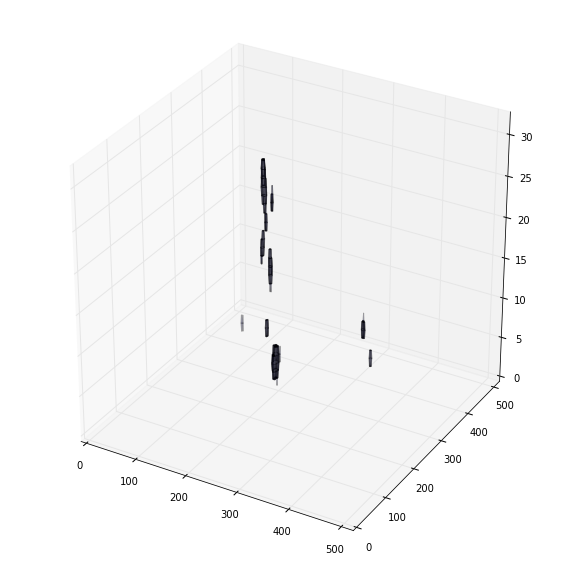

In [21]:
res1 = res.transpose(3,0,1,2)
res1[res1 >= 0.9] = 1
res1[res1 < 0.9] = 0
plot_3d(res1[0], 0)


In [22]:
np.save('segment', res1)